In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this Kaggle notebook, we use the github_repos BigQuery SQL dataset to analyse programming language usage on Github.

First, we define the client and some timing functions to test out queries before submitting them

In [2]:
from google.cloud import bigquery
from time import time

client = bigquery.Client()

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

Using Kaggle's public dataset BigQuery integration.


Get the 'languages' table from the github_repos dataset

In [3]:

dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

#dataset = client.get_dataset(dataset_ref)

table_ref = dataset_ref.table("languages")

#table = client.get_table(table_ref)

client.list_rows(table_ref, max_results=5).to_dataframe()

,repo_name,language
0,lemi136/puntovent,"[{'name': 'C', 'bytes': 80}]"
1,taxigps/nctool,"[{'name': 'C', 'bytes': 4461}]"
2,ahy1/strbuf,"[{'name': 'C', 'bytes': 5573}]"
3,nleiten/mod_rpaf-ng,"[{'name': 'C', 'bytes': 30330}]"
4,kmcallister/alameda,"[{'name': 'C', 'bytes': 17077}]"


The schame of the table. Note that 'language' is a nested and repeated column.

In [4]:
table = client.get_table(table_ref)
table.schema

[SchemaField('repo_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('language', 'RECORD', 'REPEATED', None, (SchemaField('name', 'STRING', 'NULLABLE', None, (), None), SchemaField('bytes', 'INTEGER', 'NULLABLE', None, (), None)), None)]

We make a query to determine the total amount of code (in bytes) written in each language and the total number of repos in which each language appears.

In [19]:
query = """
                    SELECT language.name AS name, SUM(language.bytes) AS bytes, count(1) AS num_repos
                    FROM `bigquery-public-data.github_repos.languages`, UNNEST(language) AS language
                    GROUP BY name
                    ORDER BY bytes DESC
                  """


show_amount_of_data_scanned(query)
show_time_to_run(query)

Data processed: 0.122 GB
Time to run: 3.771 seconds


In [20]:
# Set up the query (cancel the query if it would use too much of 
# your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query,job_config=safe_config)

result = query_job.to_dataframe() 

In [21]:
result.shape

(502, 3)

In [22]:
result.head()

,name,bytes,num_repos
0,C,5931025072304,293231
1,JavaScript,1239727221800,1099966
2,C++,516119676699,277871
3,PHP,505682751567,339426
4,HTML,352213745022,777433


In [23]:
import seaborn as sns

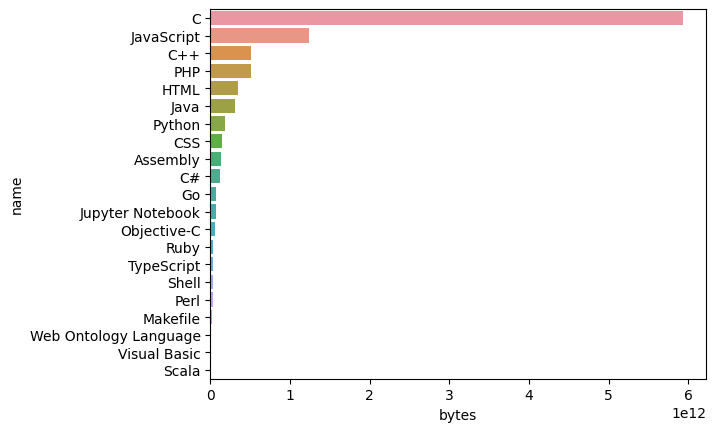

In [24]:
sns.barplot(data=result.loc[:20], y='name', x='bytes');

C is by far the most popular language by bytes written.

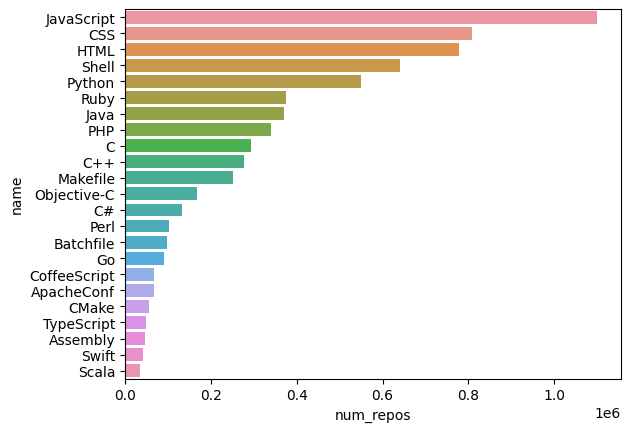

In [25]:
result2=result.sort_values('num_repos',ascending=False).copy()
sns.barplot(data=result2.loc[:20], y='name', x='num_repos');

However, Javascript is the most widespread language.